## Тестовое задание
### на позицию Junior Data Analyst

**Задание**

В архиве во вложении данные по выдачам кредитов и платежам: плановым и фактическим. Данные актуальны на 08.12.2022. Проанализируйте характер поведения клиентов с точки зрения просрочки: какая динамика просрочки, наблюдается ли рост или снижение?

**Решение**

Скачаем три csv-файла к заданию (через Google-диск)

In [2]:
! gdown 1i7wIvdl0KgArt4hwslBE6HlzvcdtVSPm
! gdown 1D9DCoCK_6vOppfG9BbqcVa0CsZtDkQ-d
! gdown 1X4c4rMZZhQ3XdvFRGegY3_TyZDbLL641

Downloading...
From: https://drive.google.com/uc?id=1i7wIvdl0KgArt4hwslBE6HlzvcdtVSPm
To: /content/plan.csv
100% 13.3M/13.3M [00:00<00:00, 58.3MB/s]
Downloading...
From: https://drive.google.com/uc?id=1D9DCoCK_6vOppfG9BbqcVa0CsZtDkQ-d
To: /content/payments.csv
100% 6.05M/6.05M [00:00<00:00, 43.2MB/s]
Downloading...
From: https://drive.google.com/uc?id=1X4c4rMZZhQ3XdvFRGegY3_TyZDbLL641
To: /content/orders.csv
100% 4.82M/4.82M [00:00<00:00, 37.1MB/s]


Посмотрим, как они выглядят.

*plan.csv*

In [3]:
import pandas as pd

df_plan = pd.read_csv('plan.csv')
# парсим строки в тип 'date'
df_plan['plan_at'] = pd.to_datetime(df_plan['plan_at']).dt.date
df_plan.head()

,order_id,plan_at,plan_sum_total
0,400001732,2022-06-02,5600.0
1,400001732,2022-07-02,9450.0
2,400001732,2022-08-01,12170.0
3,400001732,2022-08-31,14890.0
4,400001732,2022-09-30,17610.0


*payments.csv*

In [6]:
df_payments = pd.read_csv('payments.csv')
# парсим строки в тип 'date'
df_payments['paid_at'] = pd.to_datetime(df_payments['paid_at']).dt.date
df_payments.head()

,order_id,paid_at,paid_sum
0,400013633,2022-06-02,2500.0
1,400018480,2022-06-02,1070.0
2,400032001,2022-06-02,4200.0
3,400033195,2022-06-02,2850.0
4,400039407,2022-06-02,10100.0


*orders.csv*

In [4]:
df_orders = pd.read_csv('orders.csv')
df_orders.head()

,order_id,created_at,put_at,closed_at,issued_sum
0,400001732,2022-06-02 00:00:23.997,2022-06-02 20:18:00.180,2022-10-17 11:52:22.190,13600.0
1,400005838,2022-06-02 00:10:22.997,2022-06-02 15:41:33.267,2022-06-02 17:38:43.917,20000.0
2,400007915,2022-06-02 00:18:04.000,2022-06-05 19:17:38.547,2022-06-21 21:55:51.877,5820.0
3,400008952,2022-06-02 00:22:07.000,2022-06-03 14:25:18.033,2022-07-12 10:47:46.307,9000.0
4,400009027,2022-06-02 00:25:39.000,2022-06-02 00:40:40.320,2022-06-22 14:15:07.423,5000.0


(файл *orders.csv* нам не понадобится)

Посмотрим, сколько всего строк в *plan.csv* и *payments.csv*

In [7]:
print(f'Число строк в df_payments: {len(df_payments)}')
print(f'Число строк в df_plan: {len(df_plan)}')

Число строк в df_payments: 143284
Число строк в df_plan: 420282


Посмотрим разброс по датам

Для *payments.csv*:

In [8]:
df_payments['paid_at'].agg(['min', 'max'])

,paid_at
min,2022-06-02
max,2022-12-08


Для *plan.csv*:

In [9]:
df_plan['plan_at'].agg(['min', 'max'])

,plan_at
min,2022-06-02
max,2023-06-11


Плановые платежи известны до июня 2023-го, однако фактические платежи поступали до 8-го декабря 2022-го, поэтому плановые платежи позже этой даты игнорируются.

Для каждого планового платежа посчитаем фактическую накопленную сумму в столбец *paid_sum*. Чтобы в дальнейшем не повторять вычисления (накопленная сумма считается для каждой из 420-и тысяч строк), сохраним результат в файл *plan_with_total_sum.csv*

In [ ]:
def get_paid_cumsum(order_id: int, plan_at: pd.Timestamp) -> float:
    mask = (df_payments["order_id"] == order_id) & (df_payments["paid_at"] <= plan_at)
    return df_payments.loc[mask, "paid_sum"].sum()

df_plan["paid_sum_total"] = df_plan.apply(
    lambda row: get_paid_cumsum(row["order_id"], row["plan_at"]),axis=1)
df_plan.to_csv('plan_with_total_sum.csv')

Теперь скачаем csv-файл, который и будем использовать для анализа

In [10]:
! gdown 1OlIGJBhjjV1CxqcYTN559Ggp1xM73-8C

Downloading...
From: https://drive.google.com/uc?id=1OlIGJBhjjV1CxqcYTN559Ggp1xM73-8C
To: /content/plan_with_total_sum.csv
100% 18.9M/18.9M [00:00<00:00, 46.0MB/s]


Посчитаем количество неуплат в каждом месяце.

При рассчётах плановая и фактическая суммы округляются до целого.

/tmp/ipython-input-2851829497.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['is_unpaid'] = df_filtered['plan_sum_total'].round() > df_filtered['paid_sum_total'].round()


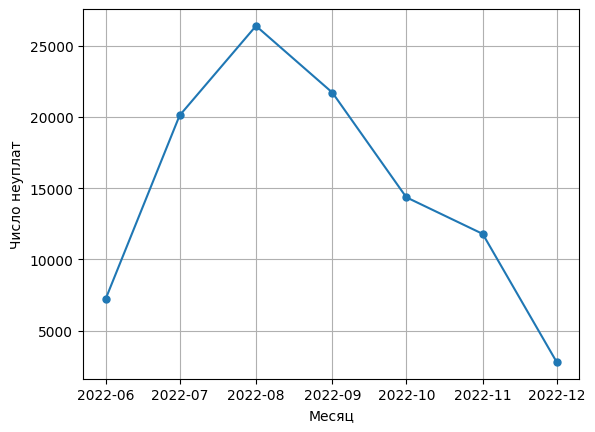

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('plan_with_total_sum.csv')
df['plan_at'] = pd.to_datetime(df['plan_at'])
mask = (df["plan_at"] >= "2022-06-01") & (df["plan_at"] <= "2022-12-08")
df_filtered = df.loc[mask]
df_filtered['is_unpaid'] = df_filtered['plan_sum_total'].round() > df_filtered['paid_sum_total'].round()
unpaid_counts = (
    df_filtered.groupby(df_filtered["plan_at"].dt.to_period("M"))["is_unpaid"].sum().reset_index(name="unpaid_count")
)
unpaid_counts["plan_at"] = unpaid_counts["plan_at"].dt.to_timestamp()
plt.plot(unpaid_counts["plan_at"], unpaid_counts["unpaid_count"], '-o', markersize=5)
plt.xlabel('Месяц')
plt.ylabel('Число неуплат')
plt.grid()
plt.show()

В декабре неуплат очень мало, поскольку данные за этот месяц неполные.

В первом месяце неуплат также (относительно) немного - около 7-и тысяч. Вероятно, это связано с тем, что начальные суммы платежей небольшие, поэтому их легко гасить в срок.

В июле и августе наблюдается стремительный рост неуплат, с пиковым значением
больше 25-и тысяч за август.

В дальнейшем число неуплат снижается, и к ноябрю их количество сокращается вдвое.


---
Посчитаем общую неуплату по кредитам за каждый месяц


/tmp/ipython-input-1379605642.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_unpaid["month"] = df_unpaid["plan_at"].dt.to_period("M")


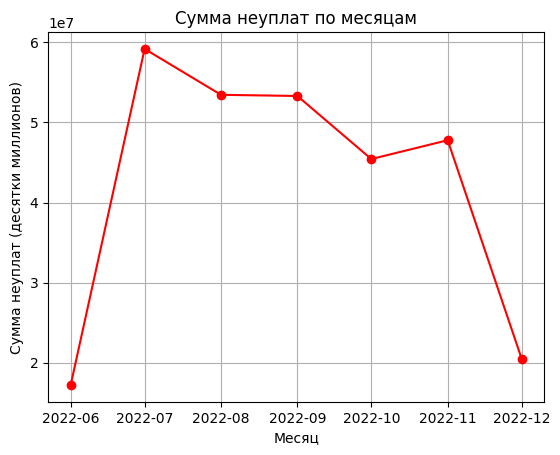

In [ ]:
df_unpaid = df_filtered[df_filtered["is_unpaid"]]
df_unpaid["month"] = df_unpaid["plan_at"].dt.to_period("M")
df_last = (
    df_unpaid.sort_values("plan_at")
    .groupby(["order_id", "month"])
    .tail(1)
)
df_last["unpaid_amount"] = df_last["plan_sum_total"] - df_last["paid_sum_total"]
monthly_unpaid = (
    df_last.groupby("month")["unpaid_amount"].sum().reset_index()
)
monthly_unpaid["month"] = monthly_unpaid["month"].dt.to_timestamp()
plt.plot(monthly_unpaid["month"], monthly_unpaid["unpaid_amount"], '-o', color='red')
plt.title("Сумма неуплат по месяцам")
plt.xlabel("Месяц")
plt.ylabel("Сумма неуплат (десятки миллионов)")
plt.grid()
plt.show()

В первом месяце общая неуплата близка к нулю, что логично;
в последнем месяце она также невелика, поскольку данные за этот месяц неполные.

Общая неуплата в первый месяц достигла максимального значения в 60 миллионов, далее постепенно снижалась.

Однако она снижается медленнее, чем число неуплат. Так, в ноябре она составляет
чуть меньше 50-и миллионов.

## Вывод

Общая динамика неуплат (как по количеству, так и по общей сумме) стремительно росла в первые два месяца (июль-август), после чего постепенно снижалась.